# Extracting features and Land Use Land Cover using Panoptic Segmentation
> * 🔬 Data Science
* 🥠 Deep Learning and Panoptic Segmentation

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#Introduction" data-toc-modified-id="Introduction">Introduction</a></span></li>
    <li><span><a href="#Export training data" data-toc-modified-id="Export training data">Export training data</a></span>
    <li><span><a href="#Train the model" data-toc-modified-id="Train the model">Train the model</a></span>
        <ul class="toc-item">
            <li><span><a href="#Necessary imports" data-toc-modified-id="Necessary imports">Necessary imports</a></span></li>
            <li><span><a href="#Get training data" data-toc-modified-id="Get training data">Get training data</a></span></li>
            <li><span><a href="#Prepare data" data-toc-modified-id="Prepare data">Prepare data</a></span></li>
            <li><span><a href="#Visualize training data" data-toc-modified-id="Visualize training data">Visualize training data</a></span></li>
            <li><span><a href="#Load model architecture" data-toc-modified-id="Load model architecture">Load model architecture</a></span></li>
            <li><span><a href="#Find an optimal learning rate" data-toc-modified-id="Find an optimal learning rate">Find an optimal learning rate</a></span></li>
            <li><span><a href="#Fit the model" data-toc-modified-id="Fit the model">Fit the model</a></span></li>
            <li><span><a href="#Visualize results in validation set" data-toc-modified-id="Visualize results in validation set">Visualize results in validation set</a></span></li>
            <li><span><a href="#Accuracy assessment" data-toc-modified-id="Accuracy assessment">Accuracy assessment</a></span></li>
            <li><span><a href="#Save the model" data-toc-modified-id="Save the model">Save the model</a></span></li></ul></li>
    <li><span><a href="#Deploy the model" data-toc-modified-id="Deploy the model">Deploy the model</a></span>
        <ul class="toc-item">
            <li><span><a href="#Results" data-toc-modified-id="Results">Results</a></span></li>
            <li><span><a href="#Visualize results using map widgets" data-toc-modified-id="Visualize results using map widgets">Visualize results using map widgets</a></span></li></ul></li>
    <li><span><a href="#Conclusion" data-toc-modified-id="Conclusion">Conclusion</a></span></li></ul></div>

## Introduction

Land cover classification is one of the most common tasks in remote sensing. It can have multiple applications and can be very useful in understanding an area, its geography, landscape, demographic, etc. Landcover classification combined with building footprints extraction and detection of other important objects can be very powerful. Currently, this is achieved through multiple models. Using Panoptic Segmentation we can detect objects of interest and also classify the pixels of a raster using a single model. 

Panoptic Segmentation works with both types of classes - stuff and things. In deep learning jargon, stuff refers to the class which is indistinctive and uncountable, for example, vegetation, road, water, sky, etc. Most of the land cover classes will classify as stuff. Things refers to classes that are distinctive, for example, buildings, cars, pools, solar panels, etc., also called the instance classes.

Panoptic Segmentation models use three inputs during training - a raster, a feature layer or a classified raster that classifies each pixel in the raster into individual classes, and a feature layer containing polygons for the objects of interest (the instance classes). This notebook demonstrates how to use the Panoptic Segmentation model MaXDeepLab to classify Land Use Land Cover (LULC) and extract building footprints and cars using very high-resolution satellite imagery of Los Angeles County. The model has been trained using the ArcGIS Python API. The trained model can then be deployed in ArcGIS Pro or ArcGIS Enterprise to classify LULC and extract building footprints and cars.

## Export training data

In [32]:
# Connect to GIS
from arcgis.gis import GIS
gis = GIS("home")
gis_ent = GIS('https://pythonapi.playground.esri.com/portal/', 'arcgis_python', 'amazing_arcgis_123')

In [20]:
gis = GIS('https://geosaurus.maps.arcgis.com/', 'arcgis_python', 'amazing_arcgis_123')

The following imagery layer contains very high resolution imagery of a part of LA County in California. The spatial resolution of the imagery is 7.5 cm (4 inches), and it contains 3 bands: Red, Green, and Blue. It is used as the 'Input Raster' for exporting the training data.

<Item title:"la_county_rgb_raster" type:Imagery Layer owner:demos_deldev>
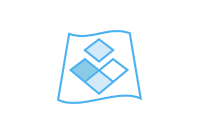

In [22]:
training_raster = gis.content.get('d3d872471fa5468da4f09ed203b15d9b')
training_raster

To export training data for panoptic segmentation we will require two input layers.
1. A feature class or a classified raster for pixel classification.
2. A feature class with polygons for the instance classes to be detected.

The following feature layer contains the polygons for the LULC classes for the corresponding imagery of LA County. It is used as the 'Input Feature Class' for exporting the training data.

<Item title:"input_features_lulc" type:Feature Layer Collection owner:api_data_owner>
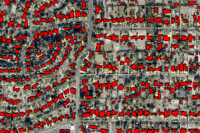

In [23]:
input_feature_class = gis.content.get('d64f11aea3ae47c19084f21c204ba318')
input_feature_class

The following feature layer contains the polygons for the building footprints and cars and will be used as the 'Instance Feature Class' for exporting the training data.

<Item title:"instance_features_buildings_cars" type:Feature Layer Collection owner:api_data_owner>
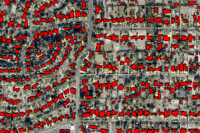

In [24]:
instance_feature_class = gis.content.get('22b83520db8f42ea98a5279b71684afd')
instance_feature_class

Training data can be exported by using the 'Export Training Data For Deep Learning' tool available in [ArcGIS Pro](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) and [ArcGIS Enterprise](https://developers.arcgis.com/rest/services-reference/export-training-data-for-deep-learning.htm). For this example, we prepared the training data in the 'Panoptic Segmentation' format, using a 'chip_size' of 512px and a 'cell_size' of 0.32 ft, in ArcGIS Pro. The 'Input Raster', the 'Input Feature Class' and the 'Instance Feature Class' have been made available to export the required training data. We have also provided a subset of the exported training data in the next section, if you wish to skip this step.

<figure>    
   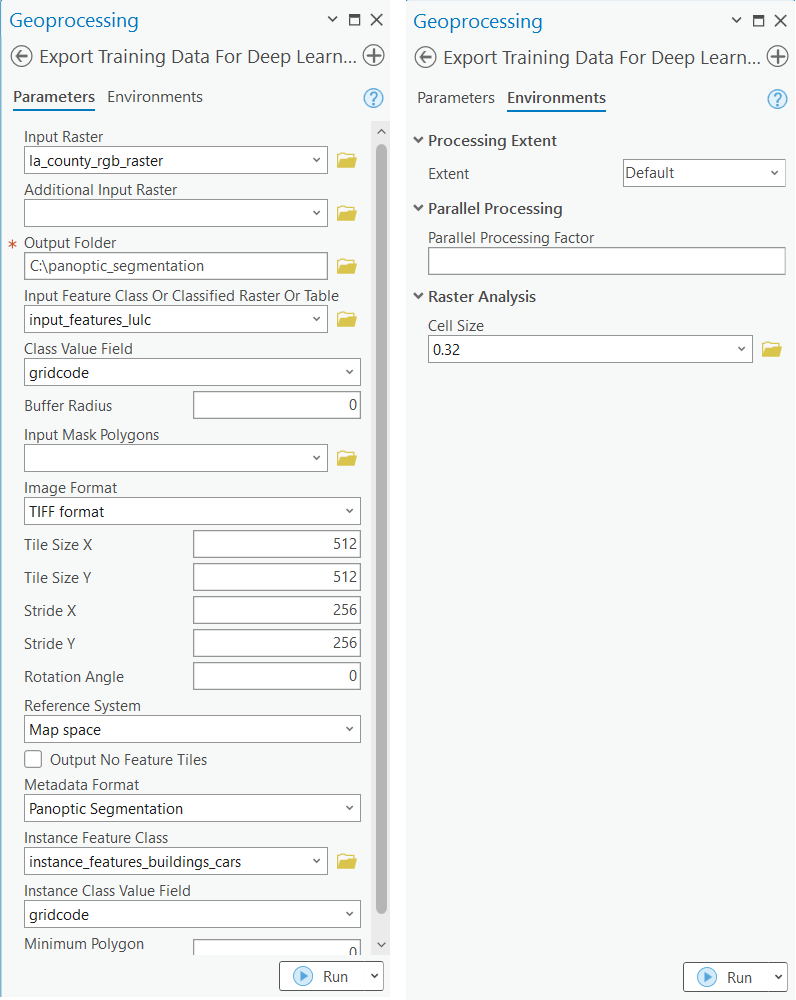
    <br>
    <center>
    <figcaption>Export Training Data for Deep Learning </figcaption>
    </center>
</figure>

## Train the model

### Necessary imports

In [1]:
%matplotlib inline

In [ ]:
import os
import zipfile
from pathlib import Path
from arcgis.learn import prepare_data, MaXDeepLab

### Get training data

We have already exported a smaller dataset and made it available so that it can be directly used by following the steps below. Exporting a larger dataset is suggested for better results.

In [6]:
training_data = gis.content.get('69544aca740d42d3a3e36f7ad5ddb485')
training_data

In [5]:
filepath = training_data.download(file_name=training_data.name)

In [6]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [7]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

### Prepare data

We will specify the path to our training data and a few hyperparameters. 

- `data_path`: path of the folder/list of folders containing training data.
- `batch_size`: Number of images your model will train on each step inside an epoch. Depends on the memory of your graphic card.
- `chip_size`: The same as the tile size used while exporting the dataset. A smaller chip_size crops the tile.
- `n_mask`: The maximum number of masks, i.e., the sum of unique instances of all things classes and total stuff classes, in a chip. The default value is 30. You can increase it if there are many objects in a single chip. A warning message will be displayed in some of the methods if the `n_mask` value is less than the number of objects in a chip. The function `compute_n_masks` can be used to calculate the maximum number of objects in any chip in a dataset. 

`batch_size`, `chip_size`, and `n_mask` will define the GPU memory requirements.

In [4]:
data = prepare_data(data_path, batch_size=4, chip_size=512, n_masks=30)

### Visualize training data

To get a sense of what the training data looks like, the `show_batch()` method will randomly pick a few training chips and visualize them. The chips are overlaid with masks representing the building footprints, cars and the lulc classes in each image chip.

/home/kapil/anaconda3/envs/arcgis201/lib/python3.9/site-packages/arcgis/learn/_data_utils/_panoptic_data.py:121: UserWarning: 50 classes and instance labels present in one of the chips but only 30 masks created. Please rerun 'prepare_data' with a higher 'n_masks' value.
  warnings.warn(
/home/kapil/anaconda3/envs/arcgis201/lib/python3.9/site-packages/arcgis/learn/_data_utils/_panoptic_data.py:121: UserWarning: 32 classes and instance labels present in one of the chips but only 30 masks created. Please rerun 'prepare_data' with a higher 'n_masks' value.
  warnings.warn(


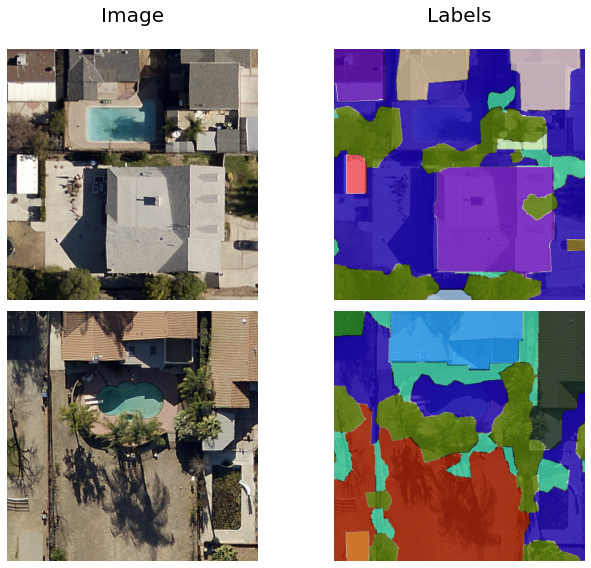

In [5]:
data.show_batch(alpha=0.8)

### Load model architecture

`arcgis.learn` provides the MaXDeepLab model for panoptic segmentation task, which is based on a transformer architecture. More details about MaXDeepLab can be found here.

In [6]:
model = MaXDeepLab(data)

### Find an optimal learning rate

Learning rate is one of the most important hyperparameters in model training. The ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

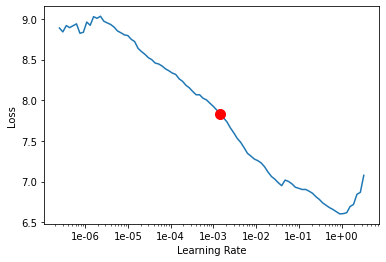

0.001445439770745928

In [7]:
lr = model.lr_find()
lr

### Fit the model 

Next, we will train the model for a few epochs with the learning rate found above. We have trained the model using a large dataset for 20 epochs. If the loss continues to reduce the model can be trained further until you start seeing overfitting.

In [9]:
model.fit(20, lr=lr)

epoch,train_loss,valid_loss,time
0,3.013765,2.962664,51:13
1,2.951099,2.877245,51:03
2,2.817451,2.777940,51:42
3,2.777210,2.683472,51:51
4,2.687376,2.612125,51:58
5,2.704202,2.614944,52:02
6,2.564810,2.567012,52:03
7,2.468962,2.545167,51:56
8,2.451628,2.680915,52:14
9,2.397162,2.388501,52:05


We can see in the following plot that although the training loss was contantly reducing gradually, the validation loss became erratic after 12th epoch. The smallest validation loss was recorded for the 17th epoch.

MaXDeepLab has a compound loss function - a combination of multiple metrics. It has been observed that longer training with a  relatively flat validation loss curve can also improve results. A diverging training and validation loss curve will still reflect overfitting.

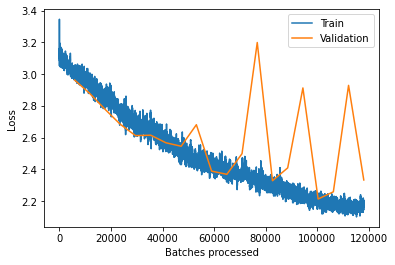

In [10]:
model.plot_losses()

### Visualize results in validation set

It is a good practice to see the results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model we trained.

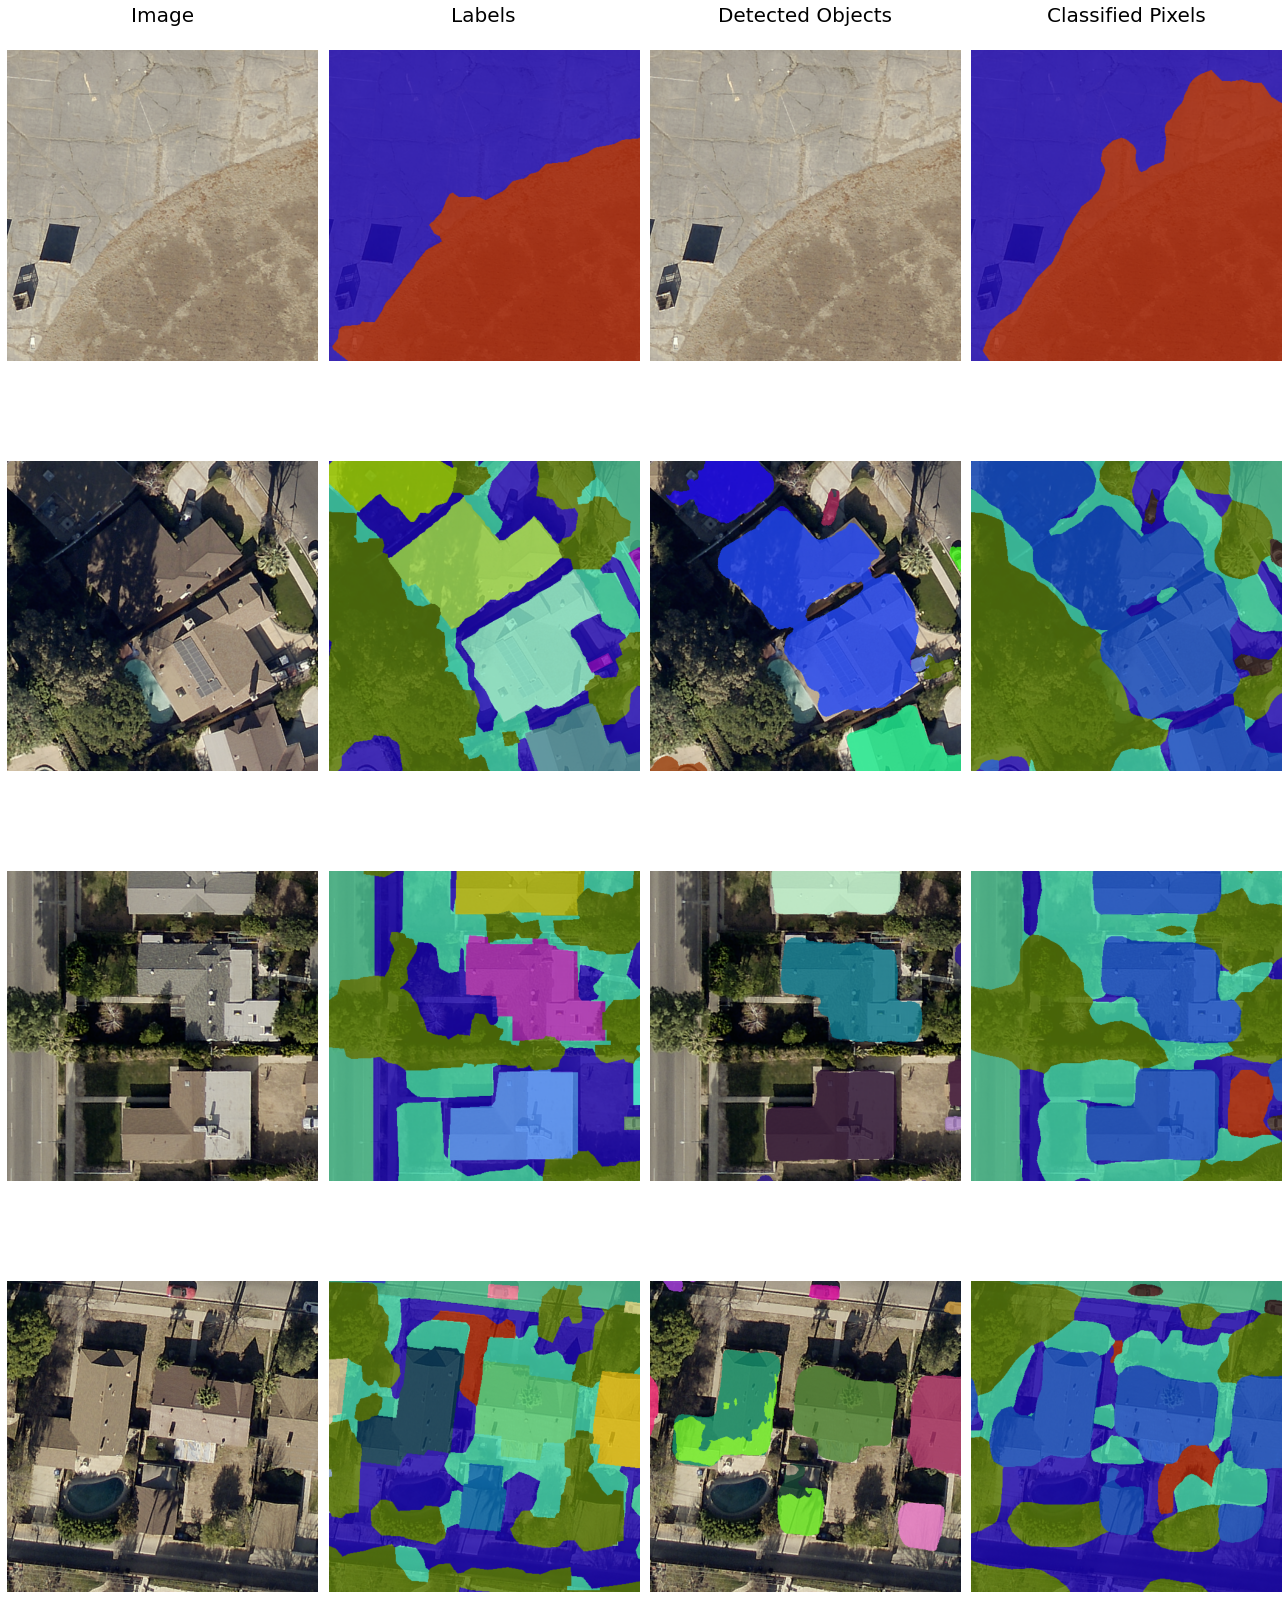

In [11]:
model.show_results(alpha=0.8)

### Accuracy assessment

MaXDeepLab provides the `panoptic_quality()` method that computes the panoptic quality, a combination of recognition and segmentation quality, of the model on the validation set.

In [13]:
model.panoptic_quality()

/home/kapil/anaconda3/envs/arcgis201/lib/python3.9/site-packages/arcgis/learn/_data_utils/_panoptic_data.py:121: UserWarning: 35 classes and instance labels present in one of the chips but only 30 masks created. Please rerun 'prepare_data' with a higher 'n_masks' value.
  warnings.warn(
/home/kapil/anaconda3/envs/arcgis201/lib/python3.9/site-packages/arcgis/learn/_data_utils/_panoptic_data.py:121: UserWarning: 42 classes and instance labels present in one of the chips but only 30 masks created. Please rerun 'prepare_data' with a higher 'n_masks' value.
  warnings.warn(
/home/kapil/anaconda3/envs/arcgis201/lib/python3.9/site-packages/arcgis/learn/_data_utils/_panoptic_data.py:121: UserWarning: 40 classes and instance labels present in one of the chips but only 30 masks created. Please rerun 'prepare_data' with a higher 'n_masks' value.
  warnings.warn(
/home/kapil/anaconda3/envs/arcgis201/lib/python3.9/site-packages/arcgis/learn/_data_utils/_panoptic_data.py:121: UserWarning: 38 classes

0.5616664

### Save the model

We will save the trained model as a 'Deep Learning Package' ('.dlpk' format). The Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. 

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [ ]:
model.save("la_panoptic_512px_ep21_lr001")

## Deploy the model

We can now use the saved model to detect buildings and cars and classify the LULC. Here, we have provided a very high resolution sample raster for LA County for inferencing. The spatial resolution of the imagery is 0.32 ft and contains 3 bands: Red, Green, and Blue.

<Item title:"panoptic_inference_raster" type:Imagery Layer owner:api_data_owner>
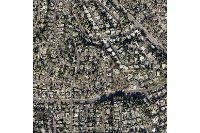

In [7]:
sample_inference_raster = gis.content.get('0c8288d76d1c4301ab8b5efbad358f39')
sample_inference_raster

We have provided a trained model to use for inferencing.

<Item title:"la_panoptic_512px_ep21_lr001" type:Deep Learning Package owner:api_data_owner>
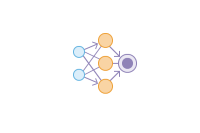

In [25]:
trained_model = gis.content.get('4ef21be1d9fb4ced9eacb306558e8edd')
trained_model

In this step, we will generate a feature layer with detected buildings and cars, and a classified raster with the LULC, using the 'Detect Objects Using Deep Learning' tool available in both ArcGIS Pro and ArcGIS Enterprise.

<figure>    
   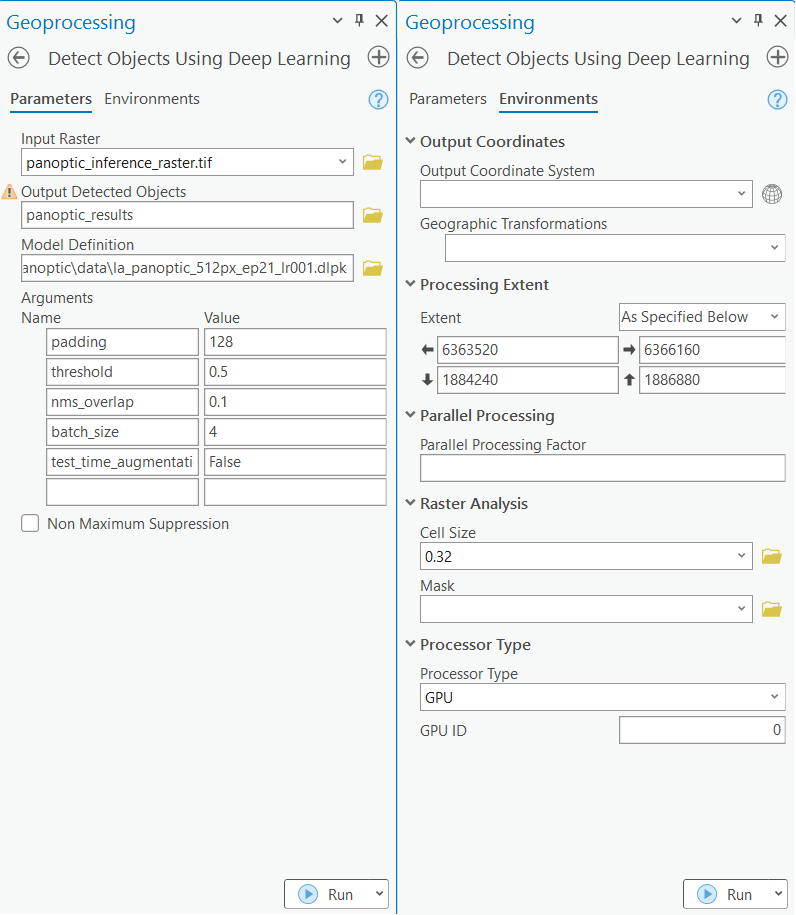
    <br>
    <center>
    <figcaption>Detect Objects Using Deep Learning</figcaption>
    </center>
</figure>

### Results

The model was run on the sample inference raster and the results can be viewed here.

<Item title:"panoptic_inference_raster" type:Imagery Layer owner:api_data_owner>
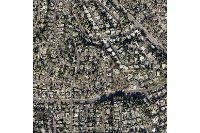

In [33]:
inference_raster = gis_ent.content.get('0c8288d76d1c4301ab8b5efbad358f39')
inference_raster

<Item title:"panoptic_resultsCP" type:Imagery Layer owner:api_data_owner>
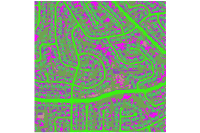

In [9]:
fc = gis.content.get('3b5033eb16044a089795682256e819ae')
fc

<Item title:"panoptic_results" type:Feature Layer Collection owner:api_data_owner>
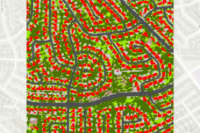

In [26]:
ic = gis.content.get('ca935d3e3e614e2392485e07ab56b97f')
ic

### Visualize results using map widgets

Two map widgets are created showing the inference raster and the results.

In [38]:
map1 = gis_ent.map()
map1.add_layer(inference_raster)
map2 = gis.map()
map2.add_layer(fc)
map2.add_layer(ic)

The maps are synchronized with each other using [MapView.sync_navigation](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html#arcgis.widgets.MapView.sync_navigation) functionality. It helps in comparing the inference raster with the results. Detailed description about advanced map widget options can be referred [here](https://developers.arcgis.com/python/guide/advanced-map-widget-usage/).

In [44]:
map2.sync_navigation(map1)

In [45]:
from ipywidgets import HBox, VBox, Label, Layout

Set the layout of the map widgets using [Hbox and Vbox](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html?highlight=hbox).

In [46]:
hbox_layout = Layout()
hbox_layout.justify_content = 'space-around'

hb1=HBox([Label('Raster'),Label('Results')])
hb1.layout=hbox_layout

In [47]:
VBox([hb1,HBox([map1,map2])])

## Conclusion

In this notebook we saw how the Panoptic Segmentation model MaXDeepLab can be used to classify pixels and detect objects at the same time. We learned how to create the data in the Panoptic Segmenation format and use it to train a model using the ArcGIS Python API. The trained model was then used to generate results for a sample raster and was displayed in the notebook.